In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [3]:
## Step 1: Load and Preprocess Data
# Load training and test datasets
df_train = pd.read_csv('trainset.csv')
df_test = pd.read_csv('testset.csv')

In [4]:
# Use closing prices
train_prices = df_train['Close'].values.reshape(-1, 1)
test_prices = df_test['Close'].values.reshape(-1, 1)

In [5]:
# Normalize the data based on training set only
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_prices)
scaled_test = scaler.transform(test_prices)

In [6]:
# Create sequences
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

seq_length = 60
x_train, y_train = create_sequences(scaled_train, seq_length)
x_test, y_test = create_sequences(scaled_test, seq_length)


In [7]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1199, 60, 1), (1199, 1), (65, 60, 1), (65, 1))

In [8]:
# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [9]:
# Create dataset and dataloader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [10]:
# Define RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

In [11]:
model = RNNModel(input_size=1, hidden_size=128, output_size=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [12]:
!pip install torchinfo

In [13]:
from torchinfo import summary

# input_size = (batch_size, seq_len, input_size)
summary(model, input_size=(64, 60, 1))

Layer (type:depth-idx)                   Output Shape              Param #
RNNModel                                 [64, 1]                   --
├─RNN: 1-1                               [64, 60, 128]             16,768
├─Linear: 1-2                            [64, 1]                   129
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 64.40
Input size (MB): 0.02
Forward/backward pass size (MB): 3.93
Params size (MB): 0.07
Estimated Total Size (MB): 4.02

In [14]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [15]:
# Train the Model
epochs=40
model.train()
train_losses=[]

for epoch in range(epochs):
    epoch_loss=0
    for x_batch, y_batch in train_loader:
        x_batch,y_batch=x_batch.to(device),y_batch.to(device)
        optimizer.zero_grad()
        outputs=model(x_batch)
        loss=criterion(outputs,y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()
    train_losses.append(epoch_loss/len(train_loader))
    print(f"Epoch [{epoch+1}/{epochs}], loss: {train_losses[-1]:.4f}")


Epoch [1/40], loss: 0.3756
Epoch [2/40], loss: 0.2276
Epoch [3/40], loss: 0.1856
Epoch [4/40], loss: 0.1150
Epoch [5/40], loss: 0.0607
Epoch [6/40], loss: 0.0515
Epoch [7/40], loss: 0.0505
Epoch [8/40], loss: 0.0458
Epoch [9/40], loss: 0.0415
Epoch [10/40], loss: 0.0337
Epoch [11/40], loss: 0.0211
Epoch [12/40], loss: 0.0070
Epoch [13/40], loss: 0.0029
Epoch [14/40], loss: 0.0024
Epoch [15/40], loss: 0.0015
Epoch [16/40], loss: 0.0014
Epoch [17/40], loss: 0.0013
Epoch [18/40], loss: 0.0017
Epoch [19/40], loss: 0.0009
Epoch [20/40], loss: 0.0009
Epoch [21/40], loss: 0.0014
Epoch [22/40], loss: 0.0011
Epoch [23/40], loss: 0.0010
Epoch [24/40], loss: 0.0029
Epoch [25/40], loss: 0.0030
Epoch [26/40], loss: 0.0014
Epoch [27/40], loss: 0.0022
Epoch [28/40], loss: 0.0013
Epoch [29/40], loss: 0.0008
Epoch [30/40], loss: 0.0011
Epoch [31/40], loss: 0.0005
Epoch [32/40], loss: 0.0010
Epoch [33/40], loss: 0.0015
Epoch [34/40], loss: 0.0018
Epoch [35/40], loss: 0.0032
Epoch [36/40], loss: 0.0007
E

Name:  Thilakeswaran KP
Register Number: 212223230232


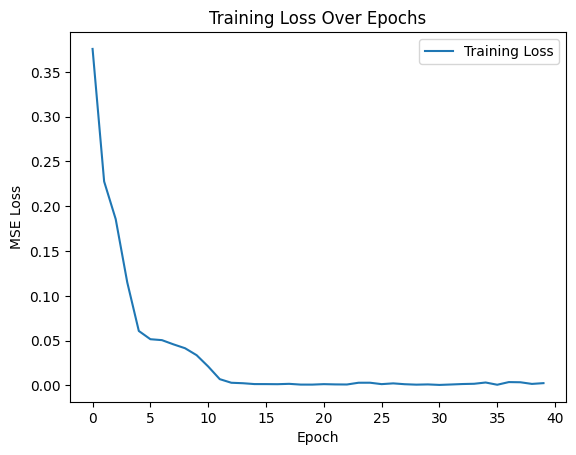

In [16]:
# Plot training loss
print('Name:  Thilakeswaran KP')
print('Register Number: 212223230232')
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


Name:  Thilakeswaran KP
Register Number: 212223230232


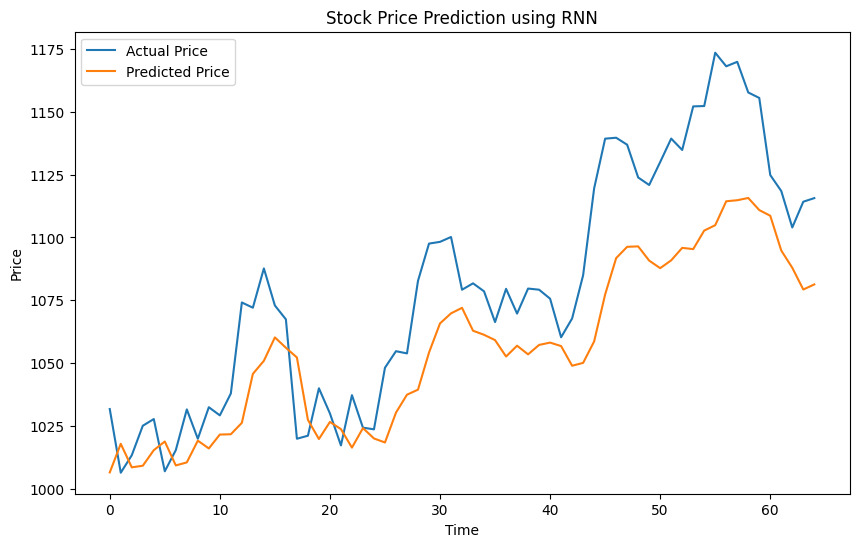

Predicted Price: [1081.3385]
Actual Price: [1115.65]


In [17]:
## Step 4: Make Predictions on Test Set
model.eval()
with torch.no_grad():
    predicted = model(x_test_tensor.to(device)).cpu().numpy()
    actual = y_test_tensor.cpu().numpy()

# Inverse transform the predictions and actual values
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(actual)

# Plot the predictions vs actual prices
print('Name:  Thilakeswaran KP')
print('Register Number: 212223230232')
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Prediction using RNN')
plt.legend()
plt.show()
print(f'Predicted Price: {predicted_prices[-1]}')
print(f'Actual Price: {actual_prices[-1]}')